# **Agente de Recolección con Reddit**

**1. Instalar dependencias mínimas**

In [1]:
!pip install -q langchain langgraph langchain-openai praw python-dotenv


In [1]:
# 📦 Cargar variables de entorno desde un archivo .env seguro
# Antes de ejecutar esta celda:
# 1️⃣ Asegúrate de haber creado un archivo llamado ".env" en la raíz del proyecto.
# 2️⃣ El archivo debe tener tus claves reales, por ejemplo:
# OPENAI_API_KEY=sk-proj-nueva_clave_aqui
# REDDIT_CLIENT_ID=tu_id_nuevo
# REDDIT_CLIENT_SECRET=tu_secret_nuevo
# REDDIT_USER_AGENT=tesis/0.1 by u/Relaty230

from dotenv import load_dotenv
import os

# Cargar las variables de entorno
load_dotenv()

# Verificación de carga (no imprime las claves)
required_vars = ["OPENAI_API_KEY", "REDDIT_CLIENT_ID", "REDDIT_CLIENT_SECRET", "REDDIT_USER_AGENT"]

missing_vars = [var for var in required_vars if not os.getenv(var)]

if missing_vars:
    print(f"⚠️ Faltan variables en .env: {', '.join(missing_vars)}")
else:
    print("✅ Todas las variables de entorno cargadas correctamente.")


✅ Todas las variables de entorno cargadas correctamente.


**2. Importaciones, configuración básica y contratos**

In [3]:
import os
import json
import praw
from typing import Any, Dict, List

from dotenv import load_dotenv
load_dotenv()

OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
REDDIT_CLIENT_ID = os.getenv("REDDIT_CLIENT_ID")
REDDIT_CLIENT_SECRET = os.getenv("REDDIT_CLIENT_SECRET")
REDDIT_USER_AGENT = os.getenv("REDDIT_USER_AGENT")

print("OK OpenAI:", bool(OPENAI_API_KEY))
print("OK Reddit:", bool(REDDIT_CLIENT_ID and REDDIT_CLIENT_SECRET and REDDIT_USER_AGENT))


OK OpenAI: True
OK Reddit: True


**3. Inicializar reddit**

In [4]:
reddit = praw.Reddit(
    client_id=REDDIT_CLIENT_ID,
    client_secret=REDDIT_CLIENT_SECRET,
    user_agent=REDDIT_USER_AGENT
)
print("Conexión Reddit lista:", reddit.read_only)


Conexión Reddit lista: True


**4. Recolectar post**

In [5]:
# Celda 4 — Recolección robusta: escanear 'new' + filtrar localmente

from datetime import datetime, timezone, timedelta
import re

def _normalize_terms(q: str) -> list[str]:
    """
    Convierte una query en lista de términos (split por espacios).
    Si quieres soportar OR/AND complejos, aquí puedes parsearlo mejor.
    """
    if not q:
        return []
    # separar por espacios, quitar comillas simples/dobles y tildes básicas
    text = q.lower().strip().replace("’", "'").replace('"', "")
    tokens = re.split(r"\s+", text)
    # filtrar vacíos
    return [t for t in tokens if t]

def _match_text(text: str, terms: list[str], mode: str = "ANY") -> bool:
    """
    Verifica si 'text' contiene los términos según 'mode' (ANY/ALL).
    """
    if not terms:
        return True
    lt = (text or "").lower()
    if mode.upper() == "ALL":
        return all(t in lt for t in terms)
    # default ANY
    return any(t in lt for t in terms)

def collect_reddit(
    subreddit: str,
    query: str,
    limit: int = 10,
    since_minutes: int = 1440,
    match: str = "ANY",
    max_fetch: int = 2000
) -> Dict[str, Any]:
    """
    Recolecta publicaciones recientes del feed 'new' y filtra localmente por keywords.

    Parámetros:
      - subreddit: sin el prefijo 'r/' (p. ej. 'ecuador')
      - query: string de keywords separados por espacio (p. ej. 'paro protesta')
      - limit: máximo a devolver tras filtrar (p. ej. 50)
      - since_minutes: ventana temporal en minutos (p. ej. 1440 = 24h)
      - match: 'ANY' o 'ALL' para coincidencia de términos
      - max_fetch: cuántos ítems de 'new' escanear (cuanto mayor, más recall)

    Estrategia:
      1) Trae hasta max_fetch posts de r/{subreddit}/new
      2) Filtra por fecha (>= now - since_minutes)
      3) Aplica filtro local de keywords (title + selftext)
      4) Devuelve hasta 'limit' resultados
    """
    out_posts: List[Dict[str, Any]] = []
    try:
        sub = reddit.subreddit(subreddit)
        # 1) Escanear 'new'
        items = sub.new(limit=max_fetch)
        cutoff = datetime.now(timezone.utc) - timedelta(minutes=since_minutes)
        terms = _normalize_terms(query)

        for post in items:
            created = datetime.fromtimestamp(post.created_utc, tz=timezone.utc)
            if created < cutoff:
                # Ya está fuera de la ventana; como 'new' viene de más nuevo a antiguo,
                # podemos romper si quisieras optimizar. Pero por seguridad, seguimos.
                pass

            body = f"{post.title or ''}\n{post.selftext or ''}"
            if _match_text(body, terms, mode=match):
                out_posts.append({
                    "id": post.id,
                    "platform": "reddit",
                    "author": str(post.author) if post.author else None,
                    "text": (post.selftext or post.title) or "",
                    "created_at": created.isoformat(timespec="seconds"),
                    "metadata": {
                        "subreddit": str(post.subreddit),
                        "permalink": f"https://reddit.com{post.permalink}"
                    }
                })

            if len(out_posts) >= limit:
                break

        return {"count": len(out_posts), "posts": out_posts}

    except Exception as e:
        return {"error": str(e), "count": 0, "posts": []}


**5. Definir tools**

In [6]:
# Celda 5 — Definición de Tools
from typing import Any, Dict, List, Type
from pydantic import BaseModel, Field
from langchain.tools import BaseTool
import json
import os

# ---- Esquema de entrada para la tool de Reddit ----
class CollectRedditInput(BaseModel):
    subreddit: str = Field(..., description="Nombre del subreddit (sin 'r/'), p.ej. 'ecuador'")
    query: str = Field(..., description="Palabras clave para buscar, p.ej. 'paro protesta'")
    limit: int = Field(10, ge=1, le=100, description="Máximo de posts a devolver (1-100)")
    since_minutes: int = Field(1440, ge=1, description="Ventana de tiempo en minutos (solo orientativo)")
    match: str = Field("ANY", description="Tipo de coincidencia (ANY/ALL). Informativo para el agente.")
    max_fetch: int = Field(2000, ge=1, description="Máximo de elementos a escanear internamente")

class RedditTool(BaseTool):
    # TIPADO de atributos de clase (requerido en Pydantic v2)
    name: str = "collect_reddit"
    description: str = "Recopila publicaciones recientes desde Reddit."
    args_schema: Type[BaseModel] = CollectRedditInput  # 👈 tipado explícito

    # Ejecuta en modo síncrono
    def _run(
        self,
        subreddit: str,
        query: str,
        limit: int = 10,
        since_minutes: int = 1440,
        match: str = "ANY",
        max_fetch: int = 2000,
    ) -> str:
        out = collect_reddit(
            subreddit=subreddit,
            query=query,
            limit=limit,
            since_minutes=since_minutes,
            match=match,
            max_fetch=max_fetch,
        )
        return json.dumps(out, ensure_ascii=False)

    # No implementamos la versión asíncrona
    def _arun(self, *args, **kwargs):
        raise NotImplementedError("Async no implementado")


# ---- Tool para guardar a JSONL ----
class SaveJsonlInput(BaseModel):
    items: List[Dict[str, Any]] = Field(..., description="Lista de objetos a guardar")

class SaveTool(BaseTool):
    name: str = "save_jsonl"
    description: str = "Guarda objetos en un archivo JSONL."
    args_schema: Type[BaseModel] = SaveJsonlInput  # 👈 tipado explícito

    def _run(self, items: List[Dict[str, Any]]) -> str:
        path = "./data/raw.jsonl"
        os.makedirs(os.path.dirname(path), exist_ok=True)
        saved = 0
        with open(path, "a", encoding="utf-8") as f:
            for it in items:
                f.write(json.dumps(it, ensure_ascii=False) + "\n")
                saved += 1
        return json.dumps({"saved": saved, "path": path}, ensure_ascii=False)

    def _arun(self, *args, **kwargs):
        raise NotImplementedError("Async no implementado")


# Instancias de las tools
reddit_tool = RedditTool()
save_tool = SaveTool()


**6. Creación del Agente con LangGraph**

In [7]:
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import create_react_agent

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0, api_key=OPENAI_API_KEY)

# Prompt simple de sistema
system_prompt = (
    "Eres un agente de recolección. Usa la herramienta 'collect_reddit' cuando el usuario lo pida. "
    "Si solicita guardar, usa 'save_jsonl'. Devuelve JSON si es posible."
)

app = create_react_agent(
    model=llm,
    tools=[reddit_tool, save_tool],
    prompt=system_prompt
)

print("Agente creado con LangGraph.")


Agente creado con LangGraph.


**7. Visualizar grafo**

=== Mermaid ===
---
config:
  flowchart:
    curve: linear
---
graph TD;
	__start__([<p>__start__</p>]):::first
	agent(agent)
	tools(tools)
	__end__([<p>__end__</p>]):::last
	__start__ --> agent;
	agent -.-> __end__;
	agent -.-> tools;
	tools --> agent;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc


=== ASCII ===
        +-----------+         
        | __start__ |         
        +-----------+         
               *              
               *              
               *              
          +-------+           
          | agent |           
          +-------+*          
          .         *         
        ..           **       
       .               *      
+---------+         +-------+ 
| __end__ |         | tools | 
+---------+         +-------+ 
None

=== PNG ===


C:\Users\Matias\anaconda3\envs\tesis\lib\site-packages\pygraphviz\agraph.py:1403: RuntimeWarning: Warning: Could not load "C:\Users\Matias\anaconda3\envs\tesis\Library\bin\gvplugin_pango.dll" - It was found, so perhaps one of its dependents was not.  Try ldd.

  data = self._run_prog("unflatten", args)


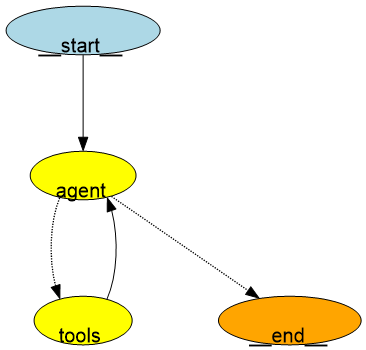

PNG exportado a agent_graph.png


In [37]:
# Celda — Instalar dependencias y dibujar el grafo (Mermaid, ASCII y PNG)

import sys, subprocess, importlib

def pip_install(pkgs):
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q"] + pkgs)

def apt_install(pkgs):
    subprocess.check_call(["apt-get", "update", "-y"], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
    subprocess.check_call(["apt-get", "install", "-y"] + pkgs, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

# 1) Instala librerías del SO necesarias para pygraphviz
try:
    import pygraphviz  # noqa
except Exception:
    apt_install(["graphviz", "libgraphviz-dev", "pkg-config"])

# 2) Instala/asegura paquetes Python
missing = []
for mod in ("grandalf", "pygraphviz"):
    try:
        importlib.import_module(mod)
    except Exception:
        missing.append(mod)
if missing:
    pip_install(missing)

# 3) Importa ya con todo instalado
from IPython.display import Image, display
import importlib
grandalf = importlib.import_module("grandalf")
pygraphviz = importlib.import_module("pygraphviz")

# 4) Obtén el grafo de tu agente LangGraph
#    OJO: usa el nombre correcto del objeto: 'app' o 'agent'
g = app.get_graph()   # cambia a agent.get_graph() si tu variable se llama 'agent'

# 5) Mermaid (siempre disponible)
print("=== Mermaid ===")
try:
    print(g.draw_mermaid())
except Exception as e:
    print("Mermaid no disponible:", e)

# 6) ASCII (requiere grandalf)
print("\n=== ASCII ===")
try:
    print(g.print_ascii())
except Exception as e:
    print("ASCII no disponible (grandalf):", e)

# 7) PNG (requiere pygraphviz + graphviz)
print("\n=== PNG ===")
try:
    png = g.draw_png()
    display(Image(data=png))
    with open("agent_graph.png", "wb") as f:
        f.write(png)
    print("PNG exportado a agent_graph.png")
except Exception as e:
    print("PNG no disponible (pygraphviz/graphviz):", e)


**8. Prueba**

In [9]:
# Celda 8A — Llamada directa a collect_reddit (sin agente), para aislar el problema

test_out = collect_reddit(
    subreddit="ecuador",
    query="paro protesta bloqueo manifestación",
    limit=10,
    since_minutes=1440,   # 24h
    match="ANY",
    max_fetch=2000        # puedes subir a 4000/8000 si quieres más recall
)

print("Directo collect_reddit -> count:", test_out.get("count"), "| error:", test_out.get("error"))
for p in (test_out.get("posts") or [])[:5]:
    meta = p.get("metadata", {}) or {}
    print("—", p.get("id"), meta.get("subreddit"), p.get("created_at"), "|", (p.get("text") or "")[:90])


Directo collect_reddit -> count: 10 | error: None
— 1o4qr0w ecuador 2025-10-12T14:39:04+00:00 | Me refiero al paro, el estado de las vías y la delincuencia. Quiero viajar seguro con la f
— 1o3fgdi ecuador 2025-10-10T22:46:00+00:00 | >La eventual [**vacancia presidencial de Dina Boluarte**](https://www.infobae.com/peru/202
— 1o0l8he ecuador 2025-10-07T17:27:15+00:00 | Viajaremos a Ecuadar y planeamos alquilar un auto para poder tener más libertad con el tie
— 1o04ke3 ecuador 2025-10-07T03:55:54+00:00 | Está claro, este gobierno con los últimos dos gobiernos (Lasso y moreno) han quedado marca
— 1nznue9 ecuador 2025-10-06T16:27:07+00:00 | Mi gente que se sabe del paro o como esta la cosa en su ciudad


In [10]:
# Celda 8B — Tool-first con FORZADO de JSON limpio (sin bloques)

import json, re
from typing import Optional
from langchain_core.messages import HumanMessage

def extract_json(text: str) -> Optional[dict]:
    if not isinstance(text, str) or not text.strip():
        return None
    try:
        return json.loads(text)
    except Exception:
        pass
    m = re.search(r"```json\s*(\{.*?\})\s*```", text, flags=re.DOTALL)
    if m:
        try: return json.loads(m.group(1))
        except: pass
    m = re.search(r"```\s*(\{.*?\})\s*```", text, flags=re.DOTALL)
    if m:
        try: return json.loads(m.group(1))
        except: pass
    start, end = text.find("{"), text.rfind("}")
    if start != -1 and end != -1 and end > start:
        try: return json.loads(text[start:end+1])
        except: pass
    return None

def last_message_text(resp: dict) -> Optional[str]:
    msgs = resp.get("messages", [])
    if not msgs: return None
    return getattr(msgs[-1], "content", None)

msg_toolfirst = (
    "Usa collect_reddit con subreddit=ecuador, "
    "query='paro protesta bloqueo manifestación', "
    "since_minutes=1440, match='ANY', limit=50, max_fetch=4000. "
    "Devuelve SOLO un objeto JSON válido, sin explicación y SIN bloques ```."
)

resp_tf = app.invoke({"messages": [HumanMessage(content=msg_toolfirst)]})
print("=== RAW RESPUESTA (tool-first) ===")
print(resp_tf)

parsed = extract_json(last_message_text(resp_tf) or "")
if parsed:
    print("\ncount:", parsed.get("count"))
    for p in (parsed.get("posts") or [])[:5]:
        meta = (p.get("metadata") or {})
        print("—", meta.get("subreddit"), ":", (p.get("text") or "")[:90])
else:
    print("\n(No se pudo parsear JSON; el modelo quizá devolvió texto. Revisa el dump de arriba.)")


=== RAW RESPUESTA (tool-first) ===
{'messages': [HumanMessage(content="Usa collect_reddit con subreddit=ecuador, query='paro protesta bloqueo manifestación', since_minutes=1440, match='ANY', limit=50, max_fetch=4000. Devuelve SOLO un objeto JSON válido, sin explicación y SIN bloques ```.", additional_kwargs={}, response_metadata={}, id='0c085785-604b-4d6d-850d-cd277f7fd583'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_bWEmJeQvd00GrxuiIo6nQ1hf', 'function': {'arguments': '{"subreddit":"ecuador","query":"paro protesta bloqueo manifestación","since_minutes":1440,"match":"ANY","limit":50,"max_fetch":4000}', 'name': 'collect_reddit'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 45, 'prompt_tokens': 309, 'total_tokens': 354, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_t

In [11]:
# Celda 8D — Guardar JSON (de la última respuesta tool-first) en ./data/raw.jsonl

from pathlib import Path
import json

DATA_DIR = Path("./data")
DATA_DIR.mkdir(exist_ok=True)
RAW_PATH = DATA_DIR / "raw.jsonl"

def extract_json(text: str):
    import re, json
    try:
        return json.loads(text)
    except Exception:
        pass
    m = re.search(r"```json\s*(\{.*?\})\s*```", text, flags=re.DOTALL)
    if m:
        try: return json.loads(m.group(1))
        except: pass
    m = re.search(r"```\s*(\{.*?\})\s*```", text, flags=re.DOTALL)
    if m:
        try: return json.loads(m.group(1))
        except: pass
    start, end = text.find("{"), text.rfind("}")
    if start != -1 and end != -1 and end > start:
        try: return json.loads(text[start:end+1])
        except: pass
    return None

from langchain_core.messages import HumanMessage

# Re-ejecutamos el tool-first por si perdiste 'parsed'
msg_toolfirst = (
    "Usa collect_reddit con subreddit=ecuador, "
    "query='paro protesta bloqueo manifestación', "
    "since_minutes=1440, match='ANY', limit=50, max_fetch=4000. "
    "Devuelve SOLO un objeto JSON válido, sin explicación y SIN bloques ```."
)
resp_tf = app.invoke({"messages": [HumanMessage(content=msg_toolfirst)]})

# Extrae JSON
txt = getattr(resp_tf.get("messages", [])[-1], "content", "") if resp_tf.get("messages") else ""
parsed = extract_json(txt) or {}

# Guarda cada post como una línea en JSONL
saved = 0
with RAW_PATH.open("a", encoding="utf-8") as f:
    for it in (parsed.get("posts") or []):
        f.write(json.dumps(it, ensure_ascii=False) + "\n")
        saved += 1

print(f"Guardados {saved} posts en {RAW_PATH}")

# Preview de 3 líneas
print("\n— Preview —")
try:
    for i, line in enumerate(RAW_PATH.open("r", encoding="utf-8")):
        if i >= 3: break
        obj = json.loads(line)
        meta = obj.get("metadata", {}) or {}
        print("•", obj.get("id"), meta.get("subreddit"), obj.get("created_at"))
except FileNotFoundError:
    print("Aún no existe el archivo.")


Guardados 22 posts en data\raw.jsonl

— Preview —
• 1o4qr0w ecuador 2025-10-12T14:39:04+00:00
• 1o3fgdi ecuador 2025-10-10T22:46:00+00:00
• 1o0l8he ecuador 2025-10-07T17:27:15+00:00


In [12]:
# Celda 8 — Agente con razonamiento (LangGraph): prompt natural → tool-calls → resumen + extracción de resultados

import json, re
from pathlib import Path
from typing import Optional, Dict, Any, List
from langchain_core.messages import HumanMessage, ToolMessage, AIMessage

# ======= Config rápida =======
PROMPT = (
    "Quiero publicaciones relacionadas con el paro en Ecuador. "
    "En tiempo real: prioriza el último día y trae varias (≈50) si están disponibles. "
    "Si conviene aumentar recall, usa coincidencia ANY y un escaneo amplio. "
    "Después de recolectar, entrégame un breve resumen en español."
)
SAVE = True                 # Guardar posts en ./data/raw.jsonl
PREVIEW_N = 10              # Cuántos posts imprimir de vista previa

# ======= Helpers =======
def extract_json(text: str) -> Optional[Dict[str, Any]]:
    """Intenta extraer un objeto JSON desde texto libre."""
    if not isinstance(text, str) or not text.strip():
        return None
    # Intento directo
    try:
        return json.loads(text)
    except Exception:
        pass
    # ```json {...}```
    m = re.search(r"```json\s*(\{.*?\})\s*```", text, flags=re.DOTALL)
    if m:
        try:
            return json.loads(m.group(1))
        except Exception:
            pass
    # ``` {...}```
    m = re.search(r"```\s*(\{.*?\})\s*```", text, flags=re.DOTALL)
    if m:
        try:
            return json.loads(m.group(1))
        except Exception:
            pass
    # recorte heurístico
    start, end = text.find("{"), text.rfind("}")
    if start != -1 and end != -1 and end > start:
        try:
            return json.loads(text[start:end+1])
        except Exception:
            pass
    return None

def find_tool_payload(messages: List, tool_name: str = "collect_reddit") -> Optional[Dict[str, Any]]:
    """
    Busca el ÚLTIMO ToolMessage de la tool indicada y parsea su .content como JSON.
    Esto captura los datos reales que devolvió la herramienta, aunque el AIMessage final sea un resumen.
    """
    for msg in reversed(messages):
        if isinstance(msg, ToolMessage) and getattr(msg, "name", None) == tool_name:
            try:
                return json.loads(msg.content)
            except Exception:
                # Si la tool devolvió texto con ```json```, hacemos un parseo robusto:
                return extract_json(msg.content)
    return None

def shorten(s: str, n: int = 90) -> str:
    s = (s or "").replace("\n", " ")
    return s if len(s) <= n else s[:n].rstrip() + "…"

# ======= Invocación del agente con un prompt natural (deja que el LLM razone) =======
resp = app.invoke({"messages": [HumanMessage(content=PROMPT)]})

# Mostramos el último mensaje del modelo (normalmente un resumen en español)
final_msgs = resp.get("messages", [])
final_text = ""
if final_msgs and isinstance(final_msgs[-1], AIMessage):
    final_text = final_msgs[-1].content or ""
print("=== RESPUESTA (resumen del agente) ===\n", final_text or "(sin resumen)")

# Extraemos la salida cruda de la tool 'collect_reddit' (si se usó)
tool_payload = find_tool_payload(final_msgs, "collect_reddit") or {}
count = tool_payload.get("count", 0)
posts = tool_payload.get("posts", []) or []

print(f"\n=== DATOS EXTRAÍDOS DE LA TOOL ===\ncount: {count}\n")
for p in posts[:PREVIEW_N]:
    meta = p.get("metadata", {}) or {}
    print("—", p.get("id"), meta.get("subreddit"), p.get("created_at"), "|", shorten(p.get("text")))

# Guardado opcional
if SAVE and posts:
    DATA_DIR = Path("./data"); DATA_DIR.mkdir(exist_ok=True)
    RAW_PATH = DATA_DIR / "raw.jsonl"
    saved = 0
    with RAW_PATH.open("a", encoding="utf-8") as f:
        for it in posts:
            f.write(json.dumps(it, ensure_ascii=False) + "\n")
            saved += 1
    print(f"\nGuardados {saved} posts en {RAW_PATH}")
elif SAVE and not posts:
    print("\n(No se guardó nada: la tool no devolvió posts).")

# Notas:
# - Aquí NO forzamos el formato de salida del modelo; dejamos que razone y decida llamar a la tool.
# - Recuperamos los datos verdaderos directamente del ToolMessage de 'collect_reddit', que es la fuente confiable.
# - Ajusta el texto de PROMPT para guiar mejor la estrategia (ventana temporal, recall vs precisión, etc.).


=== RESPUESTA (resumen del agente) ===
 He recopilado publicaciones recientes sobre el paro en Ecuador. Aquí tienes un resumen de las más relevantes:

1. **Estado de las vías y seguridad**: Un usuario expresa su preocupación por la seguridad en las vías debido al paro y busca recomendaciones para viajar con su familia. [Ver publicación](https://reddit.com/r/ecuador/comments/1o4qr0w/tengo_un_evento_en_milagro_como_están_las/)

2. **Crítica al gobierno**: Otro usuario critica a los gobiernos recientes, señalando que han sido los peores en la historia del país, mencionando escándalos y problemas en educación y salud pública, así como el impacto del paro nacional. [Ver publicación](https://reddit.com/r/ecuador/comments/1o04ke3/si_te_dieran_la_oportunidad_volverías_a_votar_por/)

3. **Consulta sobre la situación del paro**: Un usuario pregunta a la comunidad sobre la situación actual del paro en sus ciudades, buscando información actualizada. [Ver publicación](https://reddit.com/r/ecuador/c

**9. Ejecución tool first, solo JSON**

In [14]:
# Celda 12 — Exportación a CSV y métricas rápidas

import pandas as pd
from pathlib import Path

# Recuperar lo último recolectado (de Celdas 8/9/10)
posts_for_metrics = []
if 'GLOBAL_LAST_POSTS' in globals() and GLOBAL_LAST_POSTS:
    posts_for_metrics = GLOBAL_LAST_POSTS
elif 'posts_tf' in globals() and posts_tf:
    posts_for_metrics = posts_tf
elif 'posts' in globals() and posts:
    posts_for_metrics = posts

if not posts_for_metrics:
    print("No hay posts en memoria. Ejecuta antes la Celda 8, 9 o 10 para poblar datos.")
else:
    # Normalizar a DataFrame
    rows = []
    for p in posts_for_metrics:
        meta = p.get("metadata", {}) or {}
        rows.append({
            "id": p.get("id"),
            "subreddit": meta.get("subreddit"),
            "created_at": p.get("created_at"),
            "author": p.get("author"),
            "permalink": meta.get("permalink"),
            "text": p.get("text"),
        })
    df = pd.DataFrame(rows)
    print("Shape:", df.shape)

    # Exportar CSV
    out_dir = Path("./data"); out_dir.mkdir(exist_ok=True)
    csv_path = out_dir / "last_batch.csv"
    df.to_csv(csv_path, index=False)
    print("CSV guardado en:", csv_path)

    # Métricas simples
    # 1) Conteo por subreddit
    print("\n— Conteo por subreddit —")
    print(df["subreddit"].value_counts().head(10))

    # 2) Conteo por fecha (día)
    if "created_at" in df.columns:
        try:
            df["_date"] = pd.to_datetime(df["created_at"]).dt.date
            print("\n— Conteo por día —")
            print(df["_date"].value_counts().sort_index())
        except Exception:
            print("\n(No se pudo parsear 'created_at' a fecha.)")

    # 3) Longitud promedio del texto
    df["_len"] = df["text"].fillna("").map(len)
    print("\n— Longitud promedio de texto —")
    print(df["_len"].mean())


Shape: (9, 6)
CSV guardado en: data\last_batch.csv

— Conteo por subreddit —
subreddit
ecuador    9
Name: count, dtype: int64

— Conteo por día —
_date
2025-04-20    1
2025-06-12    1
2025-07-30    1
2025-09-18    1
2025-09-25    1
2025-10-05    1
2025-10-06    1
2025-10-07    1
2025-10-12    1
Name: count, dtype: int64

— Longitud promedio de texto —
516.5555555555555


**10. Guardar JSON**

In [ ]:
# Celda 10 — Guardar 'parsed' a JSONL y CSV

import os, json, csv
from pathlib import Path
from datetime import datetime

DATA_DIR = Path("./data"); DATA_DIR.mkdir(exist_ok=True)
RAW_JSONL = DATA_DIR / "raw.jsonl"
CSV_PATH  = DATA_DIR / "raw.csv"

def append_jsonl(path: Path, items):
    with path.open("a", encoding="utf-8") as f:
        for it in items:
            f.write(json.dumps(it, ensure_ascii=False) + "\n")

def write_csv(path: Path, items):
    if not items:
        return
    # aplanar lo mínimo para CSV
    rows = []
    for it in items:
        meta = it.get("metadata", {}) or {}
        rows.append({
            "id": it.get("id"),
            "platform": it.get("platform"),
            "author": it.get("author"),
            "created_at": it.get("created_at"),
            "subreddit": meta.get("subreddit"),
            "permalink": meta.get("permalink"),
            "text": it.get("text"),
        })
    # escribir
    fieldnames = ["id","platform","author","created_at","subreddit","permalink","text"]
    write_header = not path.exists()
    with path.open("a", encoding="utf-8", newline="") as f:
        w = csv.DictWriter(f, fieldnames=fieldnames)
        if write_header:
            w.writeheader()
        for r in rows:
            w.writerow(r)

if parsed and isinstance(parsed, dict):
    items = parsed.get("posts", [])
    if items:
        append_jsonl(RAW_JSONL, items)
        write_csv(CSV_PATH, items)
        print(f"✅ Guardado: {len(items)} registros -> {RAW_JSONL} y {CSV_PATH}")
    else:
        print("No hay posts en 'parsed'.")
else:
    print("No existe 'parsed' válido; ejecuta primero la Celda 9 y asegúrate de que devolvió JSON.")


In [ ]:
# Celda 11 — EDA rápido de lo recolectado (sobre raw.csv)

import pandas as pd
from pathlib import Path

CSV_PATH = Path("./data/raw.csv")
if not CSV_PATH.exists():
    print("No hay data en ./data/raw.csv. Ejecuta las celdas 9 y 10 primero.")
else:
    df = pd.read_csv(CSV_PATH)
    # Normalizar fecha a solo día
    if "created_at" in df.columns:
        df["created_day"] = pd.to_datetime(df["created_at"], errors="coerce").dt.date
    else:
        df["created_day"] = None

    print("Filas totales:", len(df))
    print("\nTop 10 autores:")
    print(df["author"].value_counts(dropna=False).head(10))

    if "created_day" in df.columns:
        print("\nPosts por día (top 10):")
        print(df["created_day"].value_counts().sort_index(ascending=False).head(10))

    if "subreddit" in df.columns:
        print("\nTop subreddits:")
        print(df["subreddit"].value_counts().head(10))


**Agente de Preprocesamiento**

In [20]:
# Dependencias livianas para preprocesamiento
%pip install -q langdetect unidecode emoji ftfy


Note: you may need to restart the kernel to use updated packages.


  DEPRECATION: Building 'langdetect' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'langdetect'. Discussion can be found at https://github.com/pypa/pip/issues/6334


**imports, helpers y estado**

In [22]:
import re, json, hashlib, unicodedata, os
from datetime import datetime
from pathlib import Path
from typing import Any, Dict, List, Optional

from langdetect import detect, DetectorFactory
from unidecode import unidecode
import emoji
import ftfy

# Para reproducibilidad en langdetect
DetectorFactory.seed = 42

# --- Configuración general ---
PIVOT_LANG = "es"            # Puedes cambiar a "en" si vas a usar modelos EN para tópico/sentimiento
USE_TRANSLATION = False      # True para traducir cuando lang != pivot (requiere API)
TRANSLATION_MODEL = "gpt-4o-mini"  # Si activas traducción
DATA_DIR = Path("./data"); DATA_DIR.mkdir(exist_ok=True)

# Stopwords básicas (amplíalas luego)
STOPWORDS_ES = {"de","la","y","que","el","en","a","los","se","del","las","por","un","una","con","para","al","lo"}
STOPWORDS_EN = {"the","and","for","you","are","this","that","with","have","from","not","your","but","all","was","will","they"}

# Índice de deduplicación persistente
DEDUP_PATH = DATA_DIR / "dedup_index.txt"
DEDUP_CACHE = set()
if DEDUP_PATH.exists():
    with DEDUP_PATH.open("r", encoding="utf-8") as f:
        for line in f:
            DEDUP_CACHE.add(line.strip())

def save_dedup(hash_id: str):
    if hash_id not in DEDUP_CACHE:
        with DEDUP_PATH.open("a", encoding="utf-8") as f:
            f.write(hash_id + "\n")
        DEDUP_CACHE.add(hash_id)

# --- Helpers de texto ---
def strip_accents_lower(s: str) -> str:
    return unidecode(ftfy.fix_text((s or "").lower())).strip()

def normalize_spaces(s: str) -> str:
    return re.sub(r"\s+", " ", (s or "")).strip()

def clean_text(raw: str) -> Dict[str, Any]:
    """Limpieza básica: URLs, menciones, hashtags, emojis → fuera; espacios normalizados."""
    t = raw or ""
    has_url = bool(re.search(r"https?://\S+|www\.\S+", t))
    t = re.sub(r"https?://\S+|www\.\S+", " ", t)
    t = re.sub(r"[@#]\w+", " ", t)              # menciones/hashtags fuera
    t = emoji.replace_emoji(t, replace=" ")     # emojis → espacio
    t = normalize_spaces(t)
    return {"text": t, "has_url": has_url}

def tokens_basic(text: str, lang: str) -> List[str]:
    toks = re.findall(r"[a-záéíóúñü]+", text.lower())
    stops = STOPWORDS_ES if lang.startswith("es") else STOPWORDS_EN
    return [t for t in toks if t not in stops and len(t) > 2]

def ngrams(tokens: List[str], n: int = 2) -> List[str]:
    return [" ".join(tokens[i:i+n]) for i in range(len(tokens)-n+1)]

def sha1(s: str) -> str:
    return "sha1:" + hashlib.sha1((s or "").encode("utf-8")).hexdigest()

def detect_lang(text: str) -> (str, float):
    try:
        lg = detect(text)
        return lg, 0.99 if lg else 0.5
    except Exception:
        return "und", 0.0


**Definición de la tool**

In [23]:
from pydantic import BaseModel, Field
from langchain.tools import BaseTool
from typing import Type

# (Opcional) LLM para traducción
from langchain_openai import ChatOpenAI

_llm = None
if USE_TRANSLATION:
    _llm = ChatOpenAI(model=TRANSLATION_MODEL, temperature=0)

class PreprocessInput(BaseModel):
    item: Dict[str, Any] = Field(..., description="Post crudo del recolector")

class PreprocessOutput(BaseModel):
    ok: bool
    item: Dict[str, Any] = {}
    reason: str = ""

class PreprocessTool(BaseTool):
    name: str = "preprocess_doc"
    description: str = "Limpia, normaliza, detecta idioma, (traduce) y genera features para análisis."
    args_schema: Type[BaseModel] = PreprocessInput

    def _translate(self, text: str, src: str, dst: str) -> str:
        if not USE_TRANSLATION or src.startswith(dst) or not _llm:
            return text
        # Prompt muy simple. Puedes mejorarlo luego con few-shots/glosarios.
        prompt = f"Traduce al {dst} conservando el sentido:\n\n{text}"
        try:
            resp = _llm.invoke(prompt)
            return (resp.content or "").strip()
        except Exception:
            # Si falla la API, retorna el texto original normalizado
            return text

    def _run(self, item: Dict[str, Any]) -> str:
        try:
            raw = (item.get("text") or "").strip()
            if not raw:
                return PreprocessOutput(ok=False, reason="texto vacío").model_dump_json(ensure_ascii=False)

            # 1) Idioma (sobre texto crudo)
            lang, lang_conf = detect_lang(raw)

            # 2) Limpieza
            cleaned = clean_text(raw)
            text_clean = cleaned["text"]
            has_url = cleaned["has_url"]

            # 3) Normalización
            text_norm = strip_accents_lower(text_clean)

            # 4) Traducción (si aplica)
            text_translated = self._translate(text_norm, lang, PIVOT_LANG)

            # 5) Tokens y ngramas (sobre texto pivot)
            toks = tokens_basic(text_translated, PIVOT_LANG)
            bigrams = ngrams(toks, 2)

            # 6) Heurística de spam sencilla
            is_spam = (len(toks) < 2) or (len(text_translated) < 10)

            # 7) Dedup robusto
            base = f"{item.get('platform','')}|{item.get('id','')}|{item.get('created_at','')}|{text_translated}"
            hash_id = sha1(base)
            is_dup = (hash_id in DEDUP_CACHE)
            save_dedup(hash_id)

            out = {
                "id": item.get("id"),
                "platform": item.get("platform"),
                "created_at": item.get("created_at"),
                "source": {
                    "subreddit": (item.get("metadata") or {}).get("subreddit"),
                    "permalink": (item.get("metadata") or {}).get("permalink"),
                },
                "lang": lang, "lang_conf": lang_conf,
                "text_raw": raw,
                "text_clean": text_clean,
                "text_norm": text_norm,
                "text_translated": text_translated,
                "tokens": toks,
                "ngrams": bigrams,
                "len_chars": len(text_translated),
                "len_tokens": len(toks),
                "flags": {
                    "is_duplicate": is_dup,
                    "is_spam": is_spam,
                    "has_url": has_url,
                    "has_mention": False
                },
                "privacy": {
                    "author_hashed": sha1(str(item.get("author","anon")))
                },
                "hash_id": hash_id,
                "pipeline_log": [
                    f"langdetect:{lang}",
                    "clean:url,mentions,hashtags,emoji",
                    "normalize:lower,accents",
                    "translate:" + ("apply" if (USE_TRANSLATION and not lang.startswith(PIVOT_LANG)) else "skip"),
                    "tokenize:basic,stopwords",
                    "ngrams:2",
                    "spam:heuristic",
                    "dedup:sha1"
                ]
            }
            return PreprocessOutput(ok=True, item=out).model_dump_json(ensure_ascii=False)

        except Exception as e:
            return PreprocessOutput(ok=False, reason=str(e)).model_dump_json(ensure_ascii=False)

    def _arun(self, *args, **kwargs):
        raise NotImplementedError("Async no implementado")

preprocess_tool = PreprocessTool()
print("PreprocessTool lista.")


PreprocessTool lista.


**Crea el agente LangGraph Preprocesamiento**

In [24]:
from langgraph.prebuilt import create_react_agent
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage

llm_pre = ChatOpenAI(model="gpt-4o-mini", temperature=0)

system_pre = (
    "Eres el Agente de Preprocesamiento. "
    "Recibirás items crudos (JSON) y debes llamar a preprocess_doc para normalizarlos. "
    "Devuelve SOLO el JSON de salida de esa tool, sin explicación y sin bloques ```."
)

preprocess_app = create_react_agent(
    model=llm_pre,
    tools=[preprocess_tool],
    prompt=system_pre
)

print("Agente de Preprocesamiento creado.")


Agente de Preprocesamiento creado.


**Conexión con Agente de recolección**

In [25]:
def load_recent_posts(max_items: int = 100) -> List[Dict[str, Any]]:
    # Prioridad: variables en memoria del Agente 1
    if 'GLOBAL_LAST_POSTS' in globals() and GLOBAL_LAST_POSTS:
        return GLOBAL_LAST_POSTS[:max_items]
    if 'posts_tf' in globals() and posts_tf:
        return posts_tf[:max_items]
    if 'posts' in globals() and posts:
        return posts[:max_items]

    # Si no hay en memoria, intenta desde JSONL
    raw_path = DATA_DIR / "raw.jsonl"
    res = []
    if raw_path.exists():
        with raw_path.open("r", encoding="utf-8") as f:
            for i, line in enumerate(f):
                if i >= max_items: break
                try:
                    obj = json.loads(line)
                    res.append(obj)
                except Exception:
                    pass
    return res

sample_posts = load_recent_posts(100)
print(f"Cargados {len(sample_posts)} posts crudos.")
if sample_posts:
    print("Ejemplo:", {k: sample_posts[0].get(k) for k in ["id","platform","created_at"]})


Cargados 9 posts crudos.
Ejemplo: {'id': '1o4qr0w', 'platform': 'reddit', 'created_at': '2025-10-12T14:39:04+00:00'}


**Procesar batch**

In [26]:
PREP_JSONL = DATA_DIR / "preprocessed.jsonl"
PREP_CSV   = DATA_DIR / "preprocessed.csv"

def flatten_for_csv(it: Dict[str, Any]) -> Dict[str, Any]:
    src = it.get("source", {}) or {}
    flags = it.get("flags", {}) or {}
    return {
        "id": it.get("id"),
        "platform": it.get("platform"),
        "created_at": it.get("created_at"),
        "subreddit": src.get("subreddit"),
        "permalink": src.get("permalink"),
        "lang": it.get("lang"),
        "len_chars": it.get("len_chars"),
        "len_tokens": it.get("len_tokens"),
        "is_duplicate": flags.get("is_duplicate"),
        "is_spam": flags.get("is_spam"),
        "text_translated": it.get("text_translated"),
    }

def preprocess_batch_direct(items: List[Dict[str, Any]], max_items: int = 50) -> List[Dict[str, Any]]:
    out = []
    for it in items[:max_items]:
        res_json = preprocess_tool._run(it)  # llamada directa determinista
        res = json.loads(res_json)
        if res.get("ok") and res.get("item"):
            out.append(res["item"])
    return out

batch = preprocess_batch_direct(sample_posts, max_items=50)
print("Procesados (directo):", len(batch))

# Guardar JSONL
saved = 0
with PREP_JSONL.open("a", encoding="utf-8") as f:
    for it in batch:
        f.write(json.dumps(it, ensure_ascii=False) + "\n")
        saved += 1
print(f"Guardados {saved} en {PREP_JSONL}")

# Guardar CSV (apéndice con encabezado condicional)
import csv
write_header = not PREP_CSV.exists()
with PREP_CSV.open("a", encoding="utf-8", newline="") as f:
    w = csv.DictWriter(f, fieldnames=list(flatten_for_csv(batch[0]).keys()) if batch else [
        "id","platform","created_at","subreddit","permalink","lang","len_chars","len_tokens","is_duplicate","is_spam","text_translated"
    ])
    if write_header:
        w.writeheader()
    for it in batch:
        w.writerow(flatten_for_csv(it))

print("CSV actualizado:", PREP_CSV)


Procesados (directo): 9
Guardados 9 en data\preprocessed.jsonl
CSV actualizado: data\preprocessed.csv


**Métricas para evaluar**

In [27]:
import pandas as pd

if not PREP_CSV.exists():
    print("Aún no hay preprocesados en CSV. Corre la Celda L primero.")
else:
    dfp = pd.read_csv(PREP_CSV)
    print("Filas totales:", len(dfp))

    print("\n— Idiomas (top) —")
    print(dfp["lang"].value_counts(dropna=False).head(10))

    print("\n— % Spam & % Duplicados —")
    print("Spam:", round(dfp["is_spam"].mean()*100, 2), "%")
    print("Duplicados:", round(dfp["is_duplicate"].mean()*100, 2), "%")

    print("\n— Longitud promedio (tokens) —")
    print(round(dfp["len_tokens"].mean(), 2))

    if "created_at" in dfp.columns:
        try:
            dfp["_day"] = pd.to_datetime(dfp["created_at"], errors="coerce").dt.date
            print("\n— Posts por día —")
            print(dfp["_day"].value_counts().sort_index())
        except Exception:
            pass


Filas totales: 9

— Idiomas (top) —
lang
es    8
en    1
Name: count, dtype: int64

— % Spam & % Duplicados —
Spam: 0.0 %
Duplicados: 0.0 %

— Longitud promedio (tokens) —
54.22

— Posts por día —
_day
2025-04-20    1
2025-06-12    1
2025-07-30    1
2025-09-18    1
2025-09-25    1
2025-10-05    1
2025-10-06    1
2025-10-07    1
2025-10-12    1
Name: count, dtype: int64


Dependencias:
 - grandalf: OK
 - pygraphviz: OK
 - graphviz (dot): C:\Users\Matias\anaconda3\envs\tesis\Library\bin\dot.EXE

=== Mermaid ===
---
config:
  flowchart:
    curve: linear
---
graph TD;
	__start__([<p>__start__</p>]):::first
	agent(agent)
	tools(tools)
	__end__([<p>__end__</p>]):::last
	__start__ --> agent;
	agent -.-> __end__;
	agent -.-> tools;
	tools --> agent;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc


=== ASCII ===
        +-----------+         
        | __start__ |         
        +-----------+         
               *              
               *              
               *              
          +-------+           
          | agent |           
          +-------+.          
          .         .         
        ..           ..       
       .               .      
+---------+         +-------+ 
| __end__ |         | tools | 
+---------+         +-------+ 
None

=== PNG ===


C:\Users\Matias\anaconda3\envs\tesis\lib\site-packages\pygraphviz\agraph.py:1403: RuntimeWarning: Warning: Could not load "C:\Users\Matias\anaconda3\envs\tesis\Library\bin\gvplugin_pango.dll" - It was found, so perhaps one of its dependents was not.  Try ldd.

  data = self._run_prog("unflatten", args)


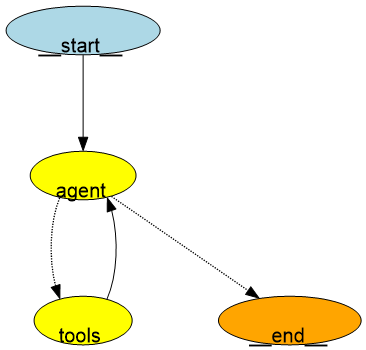

PNG exportado a preprocess_graph.png


In [38]:
# === Visualización del grafo del Agente 2 (preprocess_app) ===
# Modo: Mermaid (siempre), ASCII (si grandalf), PNG (si pygraphviz+Graphviz)

import importlib, shutil
from IPython.display import Image, display

# Verificaciones suaves
has_grandalf = importlib.util.find_spec("grandalf") is not None
has_pygraphviz = importlib.util.find_spec("pygraphviz") is not None
dot_path = shutil.which("dot")

print("Dependencias:")
print(" - grandalf:", "OK" if has_grandalf else "NO")
print(" - pygraphviz:", "OK" if has_pygraphviz else "NO")
print(" - graphviz (dot):", dot_path if dot_path else "NO")

# 1) Obtener el grafo del agente
try:
    g = preprocess_app.get_graph()  # Asegúrate de haber creado preprocess_app antes
except NameError:
    raise RuntimeError("No existe 'preprocess_app'. Ejecuta las celdas del Agente 2 antes de graficar.")

# 2) Mermaid (stdout)
print("\n=== Mermaid ===")
try:
    print(g.draw_mermaid())
except Exception as e:
    print("Mermaid no disponible:", e)

# 3) ASCII (requiere grandalf)
print("\n=== ASCII ===")
if has_grandalf:
    try:
        print(g.print_ascii())
    except Exception as e:
        print("ASCII no disponible (grandalf):", e)
else:
    print("Salta ASCII: instala 'grandalf' si lo quieres ver (pip install grandalf).")

# 4) PNG (requiere pygraphviz + Graphviz 'dot')
print("\n=== PNG ===")
if has_pygraphviz and dot_path:
    try:
        png = g.draw_png()
        with open("preprocess_graph.png", "wb") as f:
            f.write(png)
        display(Image(data=png))
        print("PNG exportado a preprocess_graph.png")
    except Exception as e:
        print("PNG no disponible (pygraphviz/graphviz):", e)
else:
    if not has_pygraphviz:
        print("Salta PNG: instala pygraphviz (recomendado con conda-forge).")
    if not dot_path:
        print("Salta PNG: no se encontró 'dot'. Instala Graphviz del sistema y agrega al PATH.")
